# Monte Carlo & Adjoint-Mode Greeks  
**Jackson Pfaff – May 2025**

---
# 1. Monte Carlo Setup (One-Step GBM)

We simulate $N$ correlated assets over the interval $[0,T]$ in a single log-Euler step:

1. **Correlation and normal draws**  
   Let $\Sigma \in \mathbb{R}^{N \times N}$ be the assets’ correlation matrix.  
   Compute its lower-triangular Cholesky factor $L$ so that $LL^\top = \Sigma$.  
   Draw:

   $$
   Z \sim \mathcal{N}(\mathbf{0}, I_N), \quad Y = LZ \quad (\text{then } \mathrm{Cov}[Y] = \Sigma)
   $$

2. **Log-price increment**  
   For each asset $i = 1, \dots, N$, compute:

   $$
   \text{drift}_i = \left( r - \tfrac{1}{2} \sigma_i^2 \right) T, \quad
   \text{diffusion}_i = \sigma_i \sqrt{T} Y_i
   $$

3. **Terminal price**  
   Define the log-argument:

   $$
   G_i = \ln S_{0,i} + \text{drift}_i + \text{diffusion}_i
   $$

   Then:

   $$
   S_i(T) = e^{G_i}
   $$

4. **Worst-of payoff**  
   $$
   S^* = \min_{1 \le i \le N} S_i(T), \quad
   A = S^* - K, \quad
   h = \max(A, 0), \quad
   D = e^{-rT}, \quad
   P = D h
   $$

5. **Monte Carlo estimator**  
   Over $M$ independent paths:

   $$
   \widehat{V} = \frac{1}{M} \sum_{m=1}^M P^{(m)} =
   \frac{e^{-rT}}{M} \sum_{m=1}^M \left( \min_i S_i^{(m)}(T) - K \right)^+
   $$

---

# 2. Adjoint-Mode Delta

We wish to compute the pathwise sensitivity $\Delta_i = \partial P / \partial S_{0,i}$ via reverse-mode (adjoint) differentiation.

1. **Initialize**  
   $\bar{P} = 1$

2. **Back through discount**  
   $P = D h$ gives:

   $$
   \bar{h} = D \bar{P}
   $$

3. **Back through ReLU payoff**  
   $h = \max(A, 0)$ gives:

   $$
   \bar{A} = \mathbb{1}_{\{A > 0\}} \bar{h}
   $$

4. **Back through subtraction**  
   $A = S^* - K$ gives:

   $$
   \bar{S}^* = \bar{A}
   $$

5. **Back through minimum**  
   $S^* = \min_i S_i(T)$ gives, for each $i$:

   $$
   \bar{S}_i(T) = \mathbb{1}_{\{i = i^*\}} \bar{S}^*, \quad
   i^* = \operatorname*{arg\,min}_i S_i(T)
   $$

6. **Back through exponential**  
   $S_i(T) = e^{G_i}$ gives:

   $$
   \bar{G}_i = S_i(T) \bar{S}_i(T)
   $$

7. **Back through log-Euler step**  
   $G_i = \ln S_{0,i} + (r - \tfrac{1}{2} \sigma_i^2)T + \sigma_i \sqrt{T} Y_i$ gives:

   $$
   \bar{S}_{0,i} = \frac{1}{S_{0,i}} \bar{G}_i
   $$

Hence the pathwise Delta is:

$$
\boxed{
\Delta_i = \frac{\partial P}{\partial S_{0,i}} =
e^{-rT} \mathbb{1}_{\{A > 0\}} \mathbb{1}_{\{i = i^*\}} \frac{S_i(T)}{S_{0,i}}
}
$$

---

# 3. Adjoint-Mode Vega

We now compute $\mathrm{Vega}_i = \partial P / \partial \sigma_i$ by continuing the reverse sweep:

8. **Back through log-Euler step ($\sigma$ branch)**  
From the full expression:

$$
G_i = \ln S_{0,i} + \left( r - \tfrac{1}{2} \sigma_i^2 \right) T + \sigma_i \sqrt{T} Y_i
$$

Differentiate with respect to $\sigma_i$:

$$
\frac{\partial G_i}{\partial \sigma_i} = -\sigma_i T + \sqrt{T} Y_i
$$

Then the adjoint is:

$$
\bar{\sigma}_i = \left( -\sigma_i T + \sqrt{T} Y_i \right) \bar{G}_i
$$

Substituting $\bar{G}_i = S_i(T) \bar{S}_i(T)$ and the definition of $Y_i = (LZ)_i$:

$$
\boxed{
\mathrm{Vega}_i = e^{-rT} \mathbb{1}_{\{A > 0\}} \mathbb{1}_{\{i = i^*\}}
S_i(T) \left( -\sigma_i T + \sqrt{T} (LZ)_i \right)
}
$$

---

This completes the in-depth adjoint derivations for both Delta and Vega.

---
## References

- Capriotti, L. (2010) *Fast Greeks by Algorithmic Differentiation*
- Ferguson, S. & Green, J. (2018) “Deeply Learning Derivatives,” 


# Monte Carlo & Greek Calculations

This notebook demonstrates worst-of basket option pricing under correlated GBM, and compares Greeks computed via finite differences and via adjoint differentiation.

In [2]:
import numpy as np, torch, math

# --- global knobs ---
torch.set_default_dtype(torch.float64)       # keep high precision
torch.manual_seed(0)                         # will be overwritten by `seed` later
N_ASSETS = 3
R_RATE   = 0.03

def cvine_corr_np(d, a=5.0, b=2.0):
    P = np.eye(d)
    for k in range(d-1):
        for i in range(k+1, d):
            rho = 2*np.random.beta(a,b)-1
            for m in range(k-1, -1, -1):
                rho = rho*np.sqrt((1-P[m,i]**2)*(1-P[m,k]**2)) + P[m,i]*P[m,k]
            P[k,i] = P[i,k] = rho
    ev, evec = np.linalg.eigh(P)
    P = evec @ np.diag(np.clip(ev,1e-6,None)) @ evec.T
    return P            # NumPy array

def fg_sample():
    z     = np.random.normal(0.5, np.sqrt(0.25), N_ASSETS)
    S0    = 100*np.exp(z)
    sigma = np.random.uniform(0, 1, N_ASSETS)
    T     = (np.random.randint(1, 44)**2) / 252.0
    return dict(
        S0    = S0,
        sigma = sigma,
        T     = T,
        rho   = cvine_corr_np(N_ASSETS),
        K     = 100.0,
        r     = R_RATE
    )

def gbm_paths_np(S0, sigma, T, r, corr, n_paths, rng):
    L   = np.linalg.cholesky(corr)
    Z   = rng.normal(size=(n_paths, len(S0)))
    Y   = Z @ L.T
    drift = (r - 0.5*sigma**2)*T
    diff  = sigma*np.sqrt(T)*Y
    return np.exp(np.log(S0) + drift + diff)     # shape (n_paths, N)


In [3]:
def delta_vega_fd(p, n_paths, rel=1e-4, rng=None):
    rng = rng or np.random.default_rng()
    S0, sigma = p['S0'], p['sigma']
    T, r, K   = p['T'],  p['r'],   p['K']
    corr      = p['rho']

    # ---------- draw common normals once ----------
    Z = rng.normal(size=(n_paths, len(S0)))
    L = np.linalg.cholesky(corr)
    Y = Z @ L.T

    disc = math.exp(-r*T)
    drift = (r - 0.5*sigma**2)*T
    diff  = sigma*np.sqrt(T)*Y
    ST    = np.exp(np.log(S0) + drift + diff)
    pay   = np.maximum(ST.min(axis=1) - K, 0.0)
    base_price = disc * pay.mean()

    delta = np.zeros_like(S0)
    vega  = np.zeros_like(sigma)

    for i in range(len(S0)):
        # ----- Delta bump (central) -----
        bump = rel * S0[i]
        for sgn, d_arr in [(+1, delta), (-1, delta)]:
            S_new = S0.copy(); S_new[i] += sgn*bump
            ST_new = np.exp(
                np.log(S_new) + drift + diff           # <–– same Y !
            )
            pay_new = np.maximum(ST_new.min(axis=1) - K, 0)
            d_arr[i] += sgn * disc * pay_new.mean() / (2*bump)

        # ----- Vega bump -----
        bump = rel * sigma[i]
        sig_new = sigma.copy(); sig_new[i] += bump
        drift_up = (r - 0.5*sig_new**2)*T
        diff_up  = sig_new*np.sqrt(T)*Y
        ST_up = np.exp(np.log(S0) + drift_up + diff_up)
        pay_up = np.maximum(ST_up.min(axis=1) - K, 0)
        vega[i] = disc * (pay_up.mean() - pay.mean()) / bump

    return base_price, delta, vega


In [4]:
def delta_vega_aad(p, n_paths, seed):
    S0, sigma = p['S0'], p['sigma']
    T, r, K   = p['T'],  p['r'],   p['K']
    corr      = p['rho']

    torch.manual_seed(seed)
    S0_t  = torch.tensor(S0,    requires_grad=True)
    sig_t = torch.tensor(sigma, requires_grad=True)
    r_t   = torch.tensor(r)
    T_t   = torch.tensor(T)
    K_t   = torch.tensor(K)
    L_t   = torch.linalg.cholesky(torch.tensor(corr))

    Z = torch.randn(n_paths, len(S0))
    Y = Z @ L_t.T

    drift = (r_t - 0.5*sig_t**2)*T_t
    diff  = sig_t*torch.sqrt(T_t)*Y
    logS  = torch.log(S0_t) + drift + diff
    ST    = torch.exp(logS)

    payoff = torch.clamp(ST.min(dim=1).values - K_t, min=0.0)
    price  = torch.exp(-r_t*T_t) * payoff.mean()

    delta, vega = torch.autograd.grad(price, (S0_t, sig_t))
    return price.item(), delta.detach().numpy(), vega.detach().numpy()


In [5]:
import time, numpy as np, torch, math
# (assume fg_sample, gbm_paths_np, delta_vega_fd, delta_vega_aad are already defined)

# ---- user knobs ----
seed     = 1234
n_paths  = 100_000_000
np.random.seed(seed)
rng      = np.random.default_rng(seed)

# ---- sample deterministic scenario ----
params = fg_sample()
print("Scenario parameters:")
print({k: params[k] for k in ['S0','sigma','T','r','K']}, "\n")

# ---- finite-difference (timed) ----
t0 = time.perf_counter()
fd_price, fd_delta, fd_vega = delta_vega_fd(params, n_paths, rng=rng)
fd_time = time.perf_counter() - t0

# ---- adjoint-mode (timed) ----
t1 = time.perf_counter()
aad_price, aad_delta, aad_vega = delta_vega_aad(params, n_paths, seed)
aad_time = time.perf_counter() - t1

# ---- identify worst asset ----
i_star = np.argmin(
    gbm_paths_np(params['S0'], params['sigma'], params['T'],
                 params['r'], params['rho'], 1, rng)[0]
)

# ---- report ----
print(f"MC paths        : {n_paths:,}")
print(f"Discount price  : {fd_price:.6f}\n")

print("Finite-Difference:")
print(f"  Δ(i*={i_star}) = {fd_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {fd_vega[i_star]:.6f}")
print(f"  time           : {fd_time:.3f} s\n")

print("Adjoint-Mode (AAD):")
print(f"  Δ(i*={i_star}) = {aad_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {aad_vega[i_star]:.6f}")
print(f"  time           : {aad_time:.3f} s\n")

speedup = fd_time / aad_time if aad_time else float('inf')
print(f"AAD speed-up ≈ {speedup:.1f}×")


Scenario parameters:
{'S0': array([208.69790336,  90.89294075, 337.48587926]), 'sigma': array([0.77997581, 0.27259261, 0.27646426]), 'T': 3.8134920634920637, 'r': 0.03, 'K': 100.0} 

MC paths        : 100,000,000
Discount price  : 12.684097

Finite-Difference:
  Δ(i*=1) = 0.329624
  ν(i*=1) = 39.763013
  time           : 78.479 s

Adjoint-Mode (AAD):
  Δ(i*=1) = 0.329725
  ν(i*=1) = 39.779329
  time           : 15.435 s

AAD speed-up ≈ 5.1×


In [6]:
import time, numpy as np, torch, math
# (assume fg_sample, gbm_paths_np, delta_vega_fd, delta_vega_aad are already defined)

# ---- user knobs ----
seed     = 12
n_paths  = 100_000_000
np.random.seed(seed)
rng      = np.random.default_rng(seed)

# ---- sample deterministic scenario ----
params = fg_sample()
print("Scenario parameters:")
print({k: params[k] for k in ['S0','sigma','T','r','K']}, "\n")

# ---- finite-difference (timed) ----
t0 = time.perf_counter()
fd_price, fd_delta, fd_vega = delta_vega_fd(params, n_paths, rng=rng)
fd_time = time.perf_counter() - t0

# ---- adjoint-mode (timed) ----
t1 = time.perf_counter()
aad_price, aad_delta, aad_vega = delta_vega_aad(params, n_paths, seed)
aad_time = time.perf_counter() - t1

# ---- identify worst asset ----
i_star = np.argmin(
    gbm_paths_np(params['S0'], params['sigma'], params['T'],
                 params['r'], params['rho'], 1, rng)[0]
)

# ---- report ----
print(f"MC paths        : {n_paths:,}")
print(f"Discount price  : {fd_price:.6f}\n")

print("Finite-Difference:")
print(f"  Δ(i*={i_star}) = {fd_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {fd_vega[i_star]:.6f}")
print(f"  time           : {fd_time:.3f} s\n")

print("Adjoint-Mode (AAD):")
print(f"  Δ(i*={i_star}) = {aad_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {aad_vega[i_star]:.6f}")
print(f"  time           : {aad_time:.3f} s\n")

speedup = fd_time / aad_time if aad_time else float('inf')
print(f"AAD speed-up ≈ {speedup:.1f}×")


Scenario parameters:
{'S0': array([208.85977666, 117.26745266, 186.11968497]), 'sigma': array([0.01457496, 0.91874701, 0.90071485]), 'T': 0.7777777777777778, 'r': 0.03, 'K': 100.0} 

MC paths        : 100,000,000
Discount price  : 20.293470

Finite-Difference:
  Δ(i*=1) = 0.219791
  ν(i*=1) = -3.918021
  time           : 83.155 s

Adjoint-Mode (AAD):
  Δ(i*=1) = 0.219760
  ν(i*=1) = -3.919039
  time           : 12.647 s

AAD speed-up ≈ 6.6×


In [7]:
import time, numpy as np, torch, math
# (assume fg_sample, gbm_paths_np, delta_vega_fd, delta_vega_aad are already defined)

# ---- user knobs ----
seed     = 123
n_paths  = 100_000_000
np.random.seed(seed)
rng      = np.random.default_rng(seed)

# ---- sample deterministic scenario ----
params = fg_sample()
print("Scenario parameters:")
print({k: params[k] for k in ['S0','sigma','T','r','K']}, "\n")

# ---- finite-difference (timed) ----
t0 = time.perf_counter()
fd_price, fd_delta, fd_vega = delta_vega_fd(params, n_paths, rng=rng)
fd_time = time.perf_counter() - t0

# ---- adjoint-mode (timed) ----
t1 = time.perf_counter()
aad_price, aad_delta, aad_vega = delta_vega_aad(params, n_paths, seed)
aad_time = time.perf_counter() - t1

# ---- identify worst asset ----
i_star = np.argmin(
    gbm_paths_np(params['S0'], params['sigma'], params['T'],
                 params['r'], params['rho'], 1, rng)[0]
)

# ---- report ----
print(f"MC paths        : {n_paths:,}")
print(f"Discount price  : {fd_price:.6f}\n")

print("Finite-Difference:")
print(f"  Δ(i*={i_star}) = {fd_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {fd_vega[i_star]:.6f}")
print(f"  time           : {fd_time:.3f} s\n")

print("Adjoint-Mode (AAD):")
print(f"  Δ(i*={i_star}) = {aad_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {aad_vega[i_star]:.6f}")
print(f"  time           : {aad_time:.3f} s\n")

speedup = fd_time / aad_time if aad_time else float('inf')
print(f"AAD speed-up ≈ {speedup:.1f}×")


Scenario parameters:
{'S0': array([ 95.80883311, 271.46763096, 189.93073157]), 'sigma': array([0.71946897, 0.42310646, 0.9807642 ]), 'T': 4.321428571428571, 'r': 0.03, 'K': 100.0} 

MC paths        : 100,000,000
Discount price  : 4.912179

Finite-Difference:
  Δ(i*=0) = 0.056646
  ν(i*=0) = -3.168893
  time           : 77.956 s

Adjoint-Mode (AAD):
  Δ(i*=0) = 0.056554
  ν(i*=0) = -3.178918
  time           : 12.779 s

AAD speed-up ≈ 6.1×


# NN Delta + Vega

Device: cuda
CUDA available: True
Vol columns : [0, 1, 2]
Spot columns: [8, 9, 10]
One forward-only     : 0.003s
One forward+backward : 0.005s
Batch cost           : 0.008s

Timing  : FD = 0.03s   AAD = 0.01s

Worst Δ  mean=2.077e-04  95%rel=3.744e-03  max_rel=5.204e-01
Worst ν  mean=2.138e-03  95%rel=2.042e-01  max_rel=2.768e+02


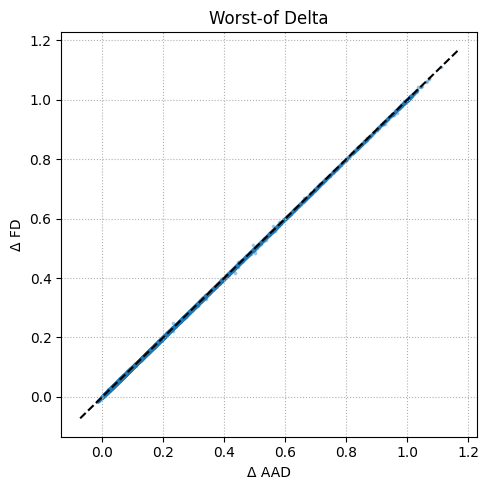

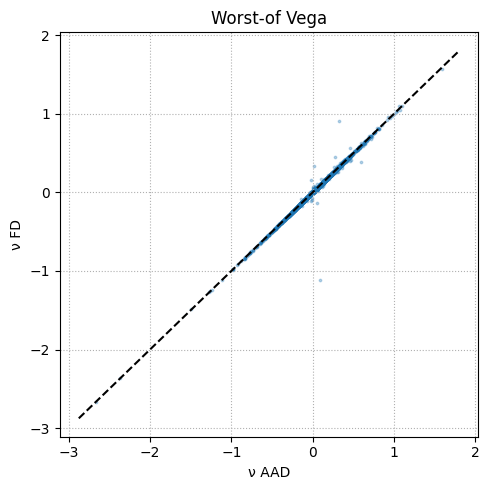

In [3]:
# ------------------------------------------------------------
# 0. Imports & device  (unchanged)
# ------------------------------------------------------------
import torch, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# Confirm device
print(f"Device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ------------------------------------------------------------
# 1. Load data & locate columns  (unchanged)
# ------------------------------------------------------------
PARQUET = "Test_clean_5k.parquet"
TARGET  = "price/k"

df        = pd.read_parquet(PARQUET, engine="pyarrow")
df_inputs = df.drop(columns=[TARGET])
feature_cols = df_inputs.columns.tolist()
name_to_idx  = {c:i for i,c in enumerate(feature_cols)}

# Basket indices (3-asset worst-of)
VOL_IDXS  = [name_to_idx[f"sigma_{i}"]  for i in range(3)]
SPOT_IDXS = [name_to_idx[f"S0_{i}/K"]   for i in range(3)]
print("Vol columns :", VOL_IDXS)
print("Spot columns:", SPOT_IDXS)

X_all = df_inputs.values.astype(np.float32)  # full dataset
IN_DIM = X_all.shape[1]

# ------------------------------------------------------------
# 2. Define & load BasketNet  (unchanged)
# ------------------------------------------------------------
class BasketNet(nn.Module):
    def __init__(self, d, w=250, L=5):
        super().__init__()
        layers = [nn.Linear(d, w), nn.ReLU()]
        for _ in range(L-1):
            layers += [nn.Linear(w, w), nn.ReLU()]
        layers.append(nn.Linear(w, 1))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self, x): return self.net(x).squeeze(-1)

MODEL_PATH = Path("model_w250_L5_bs5000_upd100000_Adam_lr0.001.pt")
assert MODEL_PATH.exists(), f"Checkpoint not found: {MODEL_PATH}"

model = BasketNet(IN_DIM).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
# freeze parameters
for p in model.parameters(): p.requires_grad_(False)

@torch.no_grad()
def price_fn(x: torch.Tensor) -> torch.Tensor:
    return model(x)

# ------------------------------------------------------------
# 3. FD Greeks (full tensor)  (unchanged)
# ------------------------------------------------------------
BUMP_PCT = 1e-4  # 1 bp relative

def delta_fd_all(x, central=True):
    p0, out = price_fn(x), []
    for idx in SPOT_IDXS:
        eps = (BUMP_PCT * x[:, idx]).unsqueeze(1)
        if central:
            xu, xd = x.clone(), x.clone()
            xu[:, idx] += eps.squeeze(1)
            xd[:, idx] -= eps.squeeze(1)
            pu, pd = price_fn(xu), price_fn(xd)
            out.append((pu - pd)/(2*eps.squeeze(1)))
        else:
            xu = x.clone(); xu[:, idx] += eps.squeeze(1)
            out.append((price_fn(xu)-p0)/eps.squeeze(1))
    return torch.stack(out, dim=1)

def vega_fd_all(x):
    p0, out = price_fn(x), []
    for idx in VOL_IDXS:
        eps = (BUMP_PCT * x[:, idx]).unsqueeze(1)
        xu = x.clone(); xu[:, idx] += eps.squeeze(1)
        out.append((price_fn(xu)-p0)/eps.squeeze(1))
    return torch.stack(out, dim=1)

# ------------------------------------------------------------
# 4. Micro-benchmark: single batch forward vs backward  (unchanged)
# ------------------------------------------------------------
BATCH = 50000
X_test = torch.from_numpy(X_all[:BATCH]).to(DEVICE)

if DEVICE.type=="cuda": torch.cuda.synchronize()
t0 = time.perf_counter(); _ = price_fn(X_test)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t1 = time.perf_counter()

xg = X_test.clone().detach().requires_grad_(True)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t2 = time.perf_counter(); out = model(xg).sum(); out.backward()
if DEVICE.type=="cuda": torch.cuda.synchronize()
t3 = time.perf_counter()

print(f"One forward-only     : {t1-t0:.3f}s")
print(f"One forward+backward : {t3-t2:.3f}s")
print(f"Batch cost           : {t3-t0:.3f}s")

# ------------------------------------------------------------
# 5. AAD in one go (full backward)  (unchanged)
# ------------------------------------------------------------
X_full = torch.from_numpy(X_all).to(DEVICE)
X_full.requires_grad_(True)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_aad0 = time.perf_counter(); out_all = model(X_full).sum(); out_all.backward()
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_aad = time.perf_counter() - t_aad0

grads_all = X_full.grad
Δ_aad_all = grads_all[:, SPOT_IDXS]
ν_aad_all = grads_all[:, VOL_IDXS]

# ------------------------------------------------------------
# 6. FD full timing & compute  (unchanged)
# ------------------------------------------------------------
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_fd0 = time.perf_counter()
Δ_fd_all = delta_fd_all(X_full)
ν_fd_all = vega_fd_all(X_full)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_fd = time.perf_counter() - t_fd0

# ------------------------------------------------------------
# 7. Worst-of stats  (unchanged)
# ------------------------------------------------------------
spots     = X_full[:, SPOT_IDXS]
worst_idx = spots.argmin(dim=1)
rows = torch.arange(len(X_full))
Δ_fd_w   = Δ_fd_all[rows, worst_idx]
Δ_aad_w  = Δ_aad_all[rows, worst_idx]
ν_fd_w   = ν_fd_all[rows, worst_idx]
ν_aad_w  = ν_aad_all[rows, worst_idx]

def stats(lbl, fd, aad):
    ae = (fd-aad).abs(); re = ae/(aad.abs()+1e-12)
    print(f"{lbl:<8} mean={ae.mean():.3e}  95%rel={re.quantile(0.95):.3e}  max_rel={re.max():.3e}")

print(f"\nTiming  : FD = {t_fd:.2f}s   AAD = {t_aad:.2f}s\n")
stats("Worst Δ", Δ_fd_w, Δ_aad_w)
stats("Worst ν", ν_fd_w, ν_aad_w)

# ------------------------------------------------------------
# 8. Plots  (detaching before scatter)
# ------------------------------------------------------------
plt.figure(figsize=(5,5))
plt.scatter(Δ_aad_w.detach().cpu(), Δ_fd_w.detach().cpu(), s=3, alpha=0.3)
lo,hi = plt.xlim(); plt.plot([lo,hi],[lo,hi],'k--')
plt.title("Worst-of Delta"); plt.xlabel("Δ AAD"); plt.ylabel("Δ FD"); plt.grid(ls=":")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(ν_aad_w.detach().cpu(), ν_fd_w.detach().cpu(), s=3, alpha=0.3)
lo,hi = plt.xlim(); plt.plot([lo,hi],[lo,hi],'k--')
plt.title("Worst-of Vega"); plt.xlabel("ν AAD"); plt.ylabel("ν FD"); plt.grid(ls=":")
plt.tight_layout(); plt.show()


Device: cuda
CUDA available: True
Vol columns : [0, 1, 2]
Spot columns: [8, 9, 10]
One forward-only     : 0.092s
One forward+backward : 0.192s
Batch cost           : 0.285s

Timing  : FD = 182.17s   AAD = 32.22s

Worst Δ  mean=2.069e-04  95%rel=4.212e-03  max_rel=1.921e+03
Worst ν  mean=2.210e-03  95%rel=1.794e-01  max_rel=1.382e+05


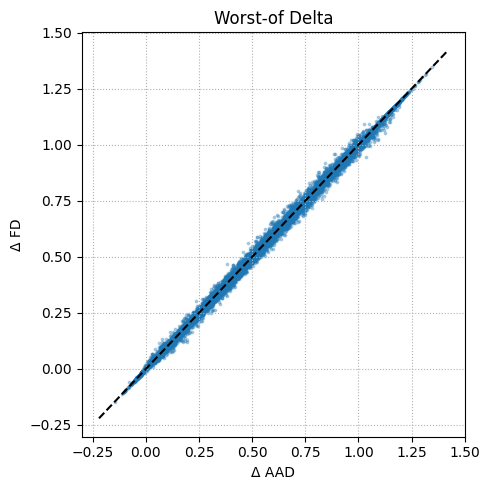

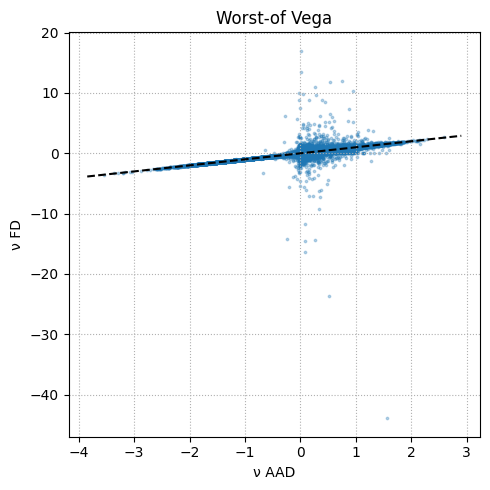

In [4]:
# ------------------------------------------------------------
# 0. Imports & device  (unchanged)
# ------------------------------------------------------------
import torch, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# Confirm device
print(f"Device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ------------------------------------------------------------
# 1. Load data & locate columns  (unchanged)
# ------------------------------------------------------------
PARQUET = "Train_clean_5m.parquet"
TARGET  = "price/k"

df        = pd.read_parquet(PARQUET, engine="pyarrow")
df_inputs = df.drop(columns=[TARGET])
feature_cols = df_inputs.columns.tolist()
name_to_idx  = {c:i for i,c in enumerate(feature_cols)}

# Basket indices (3-asset worst-of)
VOL_IDXS  = [name_to_idx[f"sigma_{i}"]  for i in range(3)]
SPOT_IDXS = [name_to_idx[f"S0_{i}/K"]   for i in range(3)]
print("Vol columns :", VOL_IDXS)
print("Spot columns:", SPOT_IDXS)

X_all = df_inputs.values.astype(np.float32)  # full dataset
IN_DIM = X_all.shape[1]

# ------------------------------------------------------------
# 2. Define & load BasketNet  (unchanged)
# ------------------------------------------------------------
class BasketNet(nn.Module):
    def __init__(self, d, w=250, L=5):
        super().__init__()
        layers = [nn.Linear(d, w), nn.ReLU()]
        for _ in range(L-1):
            layers += [nn.Linear(w, w), nn.ReLU()]
        layers.append(nn.Linear(w, 1))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self, x): return self.net(x).squeeze(-1)

MODEL_PATH = Path("model_w250_L5_bs5000_upd100000_Adam_lr0.001.pt")
assert MODEL_PATH.exists(), f"Checkpoint not found: {MODEL_PATH}"

model = BasketNet(IN_DIM).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
# freeze parameters
for p in model.parameters(): p.requires_grad_(False)

@torch.no_grad()
def price_fn(x: torch.Tensor) -> torch.Tensor:
    return model(x)

# ------------------------------------------------------------
# 3. FD Greeks (full tensor)  (unchanged)
# ------------------------------------------------------------
BUMP_PCT = 1e-4  # 1 bp relative

def delta_fd_all(x, central=True):
    p0, out = price_fn(x), []
    for idx in SPOT_IDXS:
        eps = (BUMP_PCT * x[:, idx]).unsqueeze(1)
        if central:
            xu, xd = x.clone(), x.clone()
            xu[:, idx] += eps.squeeze(1)
            xd[:, idx] -= eps.squeeze(1)
            pu, pd = price_fn(xu), price_fn(xd)
            out.append((pu - pd)/(2*eps.squeeze(1)))
        else:
            xu = x.clone(); xu[:, idx] += eps.squeeze(1)
            out.append((price_fn(xu)-p0)/eps.squeeze(1))
    return torch.stack(out, dim=1)

def vega_fd_all(x):
    p0, out = price_fn(x), []
    for idx in VOL_IDXS:
        eps = (BUMP_PCT * x[:, idx]).unsqueeze(1)
        xu = x.clone(); xu[:, idx] += eps.squeeze(1)
        out.append((price_fn(xu)-p0)/eps.squeeze(1))
    return torch.stack(out, dim=1)

# ------------------------------------------------------------
# 4. Micro-benchmark: single batch forward vs backward  (unchanged)
# ------------------------------------------------------------
BATCH = 50000
X_test = torch.from_numpy(X_all[:BATCH]).to(DEVICE)

if DEVICE.type=="cuda": torch.cuda.synchronize()
t0 = time.perf_counter(); _ = price_fn(X_test)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t1 = time.perf_counter()

xg = X_test.clone().detach().requires_grad_(True)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t2 = time.perf_counter(); out = model(xg).sum(); out.backward()
if DEVICE.type=="cuda": torch.cuda.synchronize()
t3 = time.perf_counter()

print(f"One forward-only     : {t1-t0:.3f}s")
print(f"One forward+backward : {t3-t2:.3f}s")
print(f"Batch cost           : {t3-t0:.3f}s")

# ------------------------------------------------------------
# 5. AAD in one go (full backward)  (unchanged)
# ------------------------------------------------------------
X_full = torch.from_numpy(X_all).to(DEVICE)
X_full.requires_grad_(True)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_aad0 = time.perf_counter(); out_all = model(X_full).sum(); out_all.backward()
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_aad = time.perf_counter() - t_aad0

grads_all = X_full.grad
Δ_aad_all = grads_all[:, SPOT_IDXS]
ν_aad_all = grads_all[:, VOL_IDXS]

# ------------------------------------------------------------
# 6. FD full timing & compute  (unchanged)
# ------------------------------------------------------------
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_fd0 = time.perf_counter()
Δ_fd_all = delta_fd_all(X_full)
ν_fd_all = vega_fd_all(X_full)
if DEVICE.type=="cuda": torch.cuda.synchronize()
t_fd = time.perf_counter() - t_fd0

# ------------------------------------------------------------
# 7. Worst-of stats  (unchanged)
# ------------------------------------------------------------
spots     = X_full[:, SPOT_IDXS]
worst_idx = spots.argmin(dim=1)
rows = torch.arange(len(X_full))
Δ_fd_w   = Δ_fd_all[rows, worst_idx]
Δ_aad_w  = Δ_aad_all[rows, worst_idx]
ν_fd_w   = ν_fd_all[rows, worst_idx]
ν_aad_w  = ν_aad_all[rows, worst_idx]

def stats(lbl, fd, aad):
    ae = (fd-aad).abs(); re = ae/(aad.abs()+1e-12)
    print(f"{lbl:<8} mean={ae.mean():.3e}  95%rel={re.quantile(0.95):.3e}  max_rel={re.max():.3e}")

print(f"\nTiming  : FD = {t_fd:.2f}s   AAD = {t_aad:.2f}s\n")
stats("Worst Δ", Δ_fd_w, Δ_aad_w)
stats("Worst ν", ν_fd_w, ν_aad_w)

# ------------------------------------------------------------
# 8. Plots  (detaching before scatter)
# ------------------------------------------------------------
plt.figure(figsize=(5,5))
plt.scatter(Δ_aad_w.detach().cpu(), Δ_fd_w.detach().cpu(), s=3, alpha=0.3)
lo,hi = plt.xlim(); plt.plot([lo,hi],[lo,hi],'k--')
plt.title("Worst-of Delta"); plt.xlabel("Δ AAD"); plt.ylabel("Δ FD"); plt.grid(ls=":")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(ν_aad_w.detach().cpu(), ν_fd_w.detach().cpu(), s=3, alpha=0.3)
lo,hi = plt.xlim(); plt.plot([lo,hi],[lo,hi],'k--')
plt.title("Worst-of Vega"); plt.xlabel("ν AAD"); plt.ylabel("ν FD"); plt.grid(ls=":")
plt.tight_layout(); plt.show()
